In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.utils import shuffle
from xgboost import XGBClassifier

In [4]:
df = pd.read_csv("term-deposit-marketing-2020.csv")

In [5]:
RANDOM_STATE = 200

In [39]:
def plot_roc_curve(y_true, y_score):
    from sklearn.metrics import roc_curve, auc
    
    fpr, tpr, _ = roc_curve(y_true=y_true, y_score=y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(9, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC (auc = {:0.2}'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

def plot_confusion_matrix(cm, class_names):
    import itertools
   
    cm = cm.astype(np.float) / cm.sum(axis=1)[:, np.newaxis]
 
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > cm.max() / 2 else "black"
        plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color=color)
        
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
   
    plt.show()

In [7]:
train = pd.read_csv('term-deposit-marketing-2020.csv')

print("Training Data")
print(train.shape)
print(train.head())

Training Data
(40000, 14)
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign   y  
0  unknown    5   may       261         1  no  
1  unknown    5   may       151         1  no  
2  unknown    5   may        76         1  no  
3  unknown    5   may        92         1  no  
4  unknown    5   may       198         1  no  


In [8]:
# Beginning of excel datasheet
df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [9]:
# ending of excel datasheet
df.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
39995,53,technician,married,tertiary,no,395,no,no,cellular,3,jun,107,1,no
39996,30,management,single,tertiary,no,3340,no,no,cellular,3,jun,238,3,yes
39997,54,admin,divorced,secondary,no,200,no,no,cellular,3,jun,170,1,yes
39998,34,management,married,tertiary,no,1047,no,no,cellular,3,jun,342,1,no
39999,38,technician,married,secondary,no,1442,yes,no,cellular,3,jun,113,1,no


In [10]:
# no unique
df.marital.unique()

array(['married', 'single', 'divorced'], dtype=object)

In [11]:
# no unique
df.default.unique()

array(['no', 'yes'], dtype=object)

In [12]:
# no unique
df.housing.unique()

array(['yes', 'no'], dtype=object)

In [13]:
# no unique
df.loan.unique()

array(['no', 'yes'], dtype=object)

In [14]:
# no unique
df.job.unique()

array(['management', 'technician', 'entrepreneur', 'blue-collar',
       'unknown', 'retired', 'admin', 'services', 'self-employed',
       'unemployed', 'housemaid', 'student'], dtype=object)

In [15]:
# no unique
df.duration.unique()

array([ 261,  151,   76, ..., 1880, 1460, 2219], dtype=int64)

In [16]:
# dummy encoding and one-hot encoding

# Changing yes and no's to a 1 = yes or 0 = no in the columns of default, housing, loan, and y

# Since marital, job, education, contact, and month have multiple choices within their answers, they have been seperated into
# their own seperate columns so that the computer can understand the data more efficiently. 
df_ = df.copy()


df_["default"] = df["default"].map(lambda student: 1 if student == "Yes" else 0)
df_["housing"] = df["housing"].map(lambda student: 1 if student == "Yes" else 0)
df_["loan"] = df["loan"].map(lambda student: 1 if student == "Yes" else 0)
df_["y"] = df["y"].map(lambda student: 1 if student == "Yes" else 0)

marital = pd.get_dummies(df["marital"], drop_first=True)
df_ = pd.concat([df_.drop("marital", axis=1), marital], axis=1)

job = pd.get_dummies(df["job"], drop_first=True)
df_ = pd.concat([df_.drop("job", axis=1), job], axis=1)

education = pd.get_dummies(df["education"], drop_first=True)
df_ = pd.concat([df_.drop("education", axis=1), education], axis=1)

contact = pd.get_dummies(df["contact"], drop_first=True)
df_ = pd.concat([df_.drop("contact", axis=1), contact], axis=1)

month = pd.get_dummies(df["month"], drop_first=True)
df_ = pd.concat([df_.drop("month", axis=1), month], axis=1)



# 4
df_.head()


,age,default,balance,housing,loan,day,duration,campaign,y,married,...,aug,dec,feb,jan,jul,jun,mar,may,nov,oct
0,58,0,2143,0,0,5,261,1,0,1,...,0,0,0,0,0,0,0,1,0,0
1,44,0,29,0,0,5,151,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,33,0,2,0,0,5,76,1,0,1,...,0,0,0,0,0,0,0,1,0,0
3,47,0,1506,0,0,5,92,1,0,1,...,0,0,0,0,0,0,0,1,0,0
4,33,0,1,0,0,5,198,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [17]:
# The duration tab will be changed to "Willsubsribe." Willsubsribe will be our independent variable. If the score of duration
#  is less than 100, a score of 0 will be noted, everything else is a 1.
df_["WillSubscribe"] = df["duration"].map(lambda val: 0 if val < 100 else 1)
df_.drop("duration", axis=1, inplace=True)

In [18]:
#Setting up independent and dependent variables with a .3 test size as well as a stratified split. 
X = df_[["age", "default", "campaign", "loan", "day", "y", "housing", "campaign", "married"]]
y = df_["WillSubscribe"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE,stratify=y)


In [19]:
type(y_train)

pandas.core.series.Series

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE,stratify=y)

print("Number transactions X_train dataset: ", X_train.shape)

print("Number transactions y_train dataset: ", y_train.shape)

print("Number transactions X_test dataset: ", X_test.shape)

print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (28000, 9)
Number transactions y_train dataset:  (28000,)
Number transactions X_test dataset:  (12000, 9)
Number transactions y_test dataset:  (12000,)


In [21]:
# Classification report (predictions) using logistic regression.
from sklearn.metrics import confusion_matrix, classification_report
lr = LogisticRegression()

lr.fit(X_train, y_train.ravel())

predictions = lr.predict(X_test)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.59      0.06      0.11      3000
           1       0.76      0.99      0.86      9000

    accuracy                           0.75     12000
   macro avg       0.68      0.52      0.48     12000
weighted avg       0.72      0.75      0.67     12000



In [22]:
from imblearn.over_sampling import SMOTE


In [23]:
# The original dataset is imbalanced. To handle this, one must process and oversample/undersample the data based on 
# how the data is represented. 
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))

print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

sm = SMOTE(random_state = 2)



X_train_res, y_train_res = sm.fit_resample(np.array(X_train), y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))

print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))

print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 21001
Before OverSampling, counts of label '0': 6999 

After OverSampling, the shape of train_X: (42002, 9)
After OverSampling, the shape of train_y: (42002,) 

After OverSampling, counts of label '1': 21001
After OverSampling, counts of label '0': 21001


In [41]:
lr1 = LogisticRegression()

lr1.fit(X_train_res, y_train_res.ravel())

predictions = lr1.predict(X_test)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.32      0.45      0.38      3000
           1       0.79      0.69      0.74      9000

    accuracy                           0.63     12000
   macro avg       0.56      0.57      0.56     12000
weighted avg       0.67      0.63      0.65     12000



D:\Downloads\Anucleus\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [43]:
# Undersampling
print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 1)))

print("Before Undersampling, counts of label '0': {} \n".format(sum(y_train == 0)))

from imblearn.under_sampling import NearMiss

nr = NearMiss()

X_train_miss, y_train_miss = nr.fit_resample(np.array(X_train), y_train.ravel())

print('After Undersampling, the shape of train_X: {}'.format(X_train_miss.shape))

print('After Undersampling, the shape of train_y: {} \n'.format(y_train_miss.shape))

print("After Undersampling, counts of label '1': {}".format(sum(y_train_miss == 1)))

print("After Undersampling, counts of label '0': {}".format(sum(y_train_miss == 0)))

Before Undersampling, counts of label '1': 21001
Before Undersampling, counts of label '0': 6999 

After Undersampling, the shape of train_X: (13998, 9)
After Undersampling, the shape of train_y: (13998,) 

After Undersampling, counts of label '1': 6999
After Undersampling, counts of label '0': 6999


In [44]:
#Checking for any miss's
lr2 = LogisticRegression()

lr2.fit(X_train_miss, y_train_miss.ravel())

predictions = lr2.predict(X_test)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.30      0.56      0.39      3000
           1       0.79      0.56      0.66      9000

    accuracy                           0.56     12000
   macro avg       0.55      0.56      0.52     12000
weighted avg       0.67      0.56      0.59     12000



D:\Downloads\Anucleus\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [45]:
#insert class imbalance information

In [51]:
#creating a pipeline
scaler = StandardScaler()
param_grid = dict(C=np.logspace(-5, 5, 11), penalty=['l2', 'l2'])
regr = LogisticRegression(random_state=RANDOM_STATE)
cv = GridSearchCV(estimator=regr, param_grid=param_grid, scoring='average_precision')
pipeline = make_pipeline(scaler, cv)

pipeline.fit(X_train, y_train)


y_true = y_test
y_pred = pipeline.predict(X_test)
y_score = pipeline.predict_proba(X_test)[:, 1]


In [52]:
#Estimator
estimator = LogisticRegression(random_state=RANDOM_STATE)
estimator.fit(X_train, y_train)

y_true = y_test  # 3
y_pred = estimator.predict(X_test)  # 4
y_score = estimator.predict_proba(X_test)[:, 1]  # 5

In [53]:
#XGB boost is a gradient type of booster
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

In [57]:
# Parameters 
params = { 'class_weight': [4,5,6],
           'verbose': [0.01, 0.5, 0.6, 0.7],
           'random_state': [100, 500, 1000],
           'fit_intercept': [0.7, 0.8, 0.9]}

clf = GridSearchCV(estimator=regr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=2)

clf.fit(X,y)



Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END class_weight=4, fit_intercept=0.7, random_state=100, verbose=0.01; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.7, random_state=100, verbose=0.01; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.7, random_state=100, verbose=0.01; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.7, random_state=100, verbose=0.01; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.7, random_state=100, verbose=0.01; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.7, random_state=100, verbose=0.5; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.7, random_state=100, verbose=0.5; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.7, random_state=100, verbose=0.5; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.7, random_state=100, verbose=0.5; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.7, random_state=100, verbose=0.5; total time=

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using 

[CV] END class_weight=4, fit_intercept=0.7, random_state=500, verbose=0.01; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.7, random_state=500, verbose=0.01; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.7, random_state=500, verbose=0.01; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.7, random_state=500, verbose=0.01; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.7, random_state=500, verbose=0.5; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.7, random_state=500, verbose=0.5; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.7, random_state=500, verbose=0.5; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.7, random_state=500, verbose=0.5; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.7, random_state=500, verbose=0.5; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.7, random_state=500, verbose=0.6; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.7, random_state

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using 

[CV] END class_weight=4, fit_intercept=0.7, random_state=1000, verbose=0.01; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.7, random_state=1000, verbose=0.5; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.7, random_state=1000, verbose=0.5; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.7, random_state=1000, verbose=0.5; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.7, random_state=1000, verbose=0.5; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.7, random_state=1000, verbose=0.5; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.7, random_state=1000, verbose=0.6; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.7, random_state=1000, verbose=0.6; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.7, random_state=1000, verbose=0.6; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.7, random_state=1000, verbose=0.6; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.7, rando

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using 

[CV] END class_weight=4, fit_intercept=0.8, random_state=100, verbose=0.5; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.8, random_state=100, verbose=0.5; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.8, random_state=100, verbose=0.5; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.8, random_state=100, verbose=0.6; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.8, random_state=100, verbose=0.6; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.8, random_state=100, verbose=0.6; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.8, random_state=100, verbose=0.6; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.8, random_state=100, verbose=0.6; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.8, random_state=100, verbose=0.7; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.8, random_state=100, verbose=0.7; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.8, random_state=100

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using 

[CV] END class_weight=4, fit_intercept=0.8, random_state=1000, verbose=0.6; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.8, random_state=1000, verbose=0.6; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.8, random_state=1000, verbose=0.6; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.8, random_state=1000, verbose=0.6; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.8, random_state=1000, verbose=0.7; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.8, random_state=1000, verbose=0.7; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.8, random_state=1000, verbose=0.7; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.8, random_state=1000, verbose=0.7; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.8, random_state=1000, verbose=0.7; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.9, random_state=100, verbose=0.01; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.9, random

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using 

[CV] END class_weight=4, fit_intercept=0.9, random_state=500, verbose=0.6; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.9, random_state=500, verbose=0.7; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.9, random_state=500, verbose=0.7; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.9, random_state=500, verbose=0.7; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.9, random_state=500, verbose=0.7; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.9, random_state=500, verbose=0.7; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.9, random_state=1000, verbose=0.01; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.9, random_state=1000, verbose=0.01; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.9, random_state=1000, verbose=0.01; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.9, random_state=1000, verbose=0.01; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.9, random_s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using 

[CV] END class_weight=4, fit_intercept=0.9, random_state=1000, verbose=0.7; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.9, random_state=1000, verbose=0.7; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.9, random_state=1000, verbose=0.7; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.9, random_state=1000, verbose=0.7; total time=   0.0s
[CV] END class_weight=4, fit_intercept=0.9, random_state=1000, verbose=0.7; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.7, random_state=100, verbose=0.01; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.7, random_state=100, verbose=0.01; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.7, random_state=100, verbose=0.01; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.7, random_state=100, verbose=0.01; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.7, random_state=100, verbose=0.01; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.7, random

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using 

[CV] END class_weight=5, fit_intercept=0.7, random_state=1000, verbose=0.01; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.7, random_state=1000, verbose=0.01; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.7, random_state=1000, verbose=0.01; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.7, random_state=1000, verbose=0.01; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.7, random_state=1000, verbose=0.01; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.7, random_state=1000, verbose=0.5; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.7, random_state=1000, verbose=0.5; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.7, random_state=1000, verbose=0.5; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.7, random_state=1000, verbose=0.5; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.7, random_state=1000, verbose=0.5; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.7, r

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using 

[CV] END class_weight=5, fit_intercept=0.8, random_state=500, verbose=0.01; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.8, random_state=500, verbose=0.01; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.8, random_state=500, verbose=0.01; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.8, random_state=500, verbose=0.5; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.8, random_state=500, verbose=0.5; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.8, random_state=500, verbose=0.5; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.8, random_state=500, verbose=0.5; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.8, random_state=500, verbose=0.5; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.8, random_state=500, verbose=0.6; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.8, random_state=500, verbose=0.6; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.8, random_state=

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using 

[CV] END class_weight=5, fit_intercept=0.8, random_state=1000, verbose=0.01; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.8, random_state=1000, verbose=0.01; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.8, random_state=1000, verbose=0.5; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.8, random_state=1000, verbose=0.5; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.8, random_state=1000, verbose=0.5; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.8, random_state=1000, verbose=0.5; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.8, random_state=1000, verbose=0.5; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.8, random_state=1000, verbose=0.6; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.8, random_state=1000, verbose=0.6; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.8, random_state=1000, verbose=0.6; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.8, rand

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using 

[CV] END class_weight=5, fit_intercept=0.9, random_state=100, verbose=0.01; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.9, random_state=100, verbose=0.5; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.9, random_state=100, verbose=0.5; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.9, random_state=100, verbose=0.5; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.9, random_state=100, verbose=0.5; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.9, random_state=100, verbose=0.5; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.9, random_state=100, verbose=0.6; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.9, random_state=100, verbose=0.6; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.9, random_state=100, verbose=0.6; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.9, random_state=100, verbose=0.6; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.9, random_state=10

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using 

[CV] END class_weight=5, fit_intercept=0.9, random_state=500, verbose=0.5; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.9, random_state=500, verbose=0.5; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.9, random_state=500, verbose=0.5; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.9, random_state=500, verbose=0.5; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.9, random_state=500, verbose=0.5; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.9, random_state=500, verbose=0.6; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.9, random_state=500, verbose=0.6; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.9, random_state=500, verbose=0.6; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.9, random_state=500, verbose=0.6; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.9, random_state=500, verbose=0.6; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.9, random_state=500

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using 

[CV] END class_weight=5, fit_intercept=0.9, random_state=1000, verbose=0.5; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.9, random_state=1000, verbose=0.5; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.9, random_state=1000, verbose=0.6; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.9, random_state=1000, verbose=0.6; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.9, random_state=1000, verbose=0.6; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.9, random_state=1000, verbose=0.6; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.9, random_state=1000, verbose=0.6; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.9, random_state=1000, verbose=0.7; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.9, random_state=1000, verbose=0.7; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.9, random_state=1000, verbose=0.7; total time=   0.0s
[CV] END class_weight=5, fit_intercept=0.9, random

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using 

[CV] END class_weight=6, fit_intercept=0.7, random_state=100, verbose=0.5; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.7, random_state=100, verbose=0.6; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.7, random_state=100, verbose=0.6; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.7, random_state=100, verbose=0.6; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.7, random_state=100, verbose=0.6; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.7, random_state=100, verbose=0.6; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.7, random_state=100, verbose=0.7; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.7, random_state=100, verbose=0.7; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.7, random_state=100, verbose=0.7; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.7, random_state=100, verbose=0.7; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.7, random_state=100

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using 

[CV] END class_weight=6, fit_intercept=0.7, random_state=500, verbose=0.6; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.7, random_state=500, verbose=0.6; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.7, random_state=500, verbose=0.6; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.7, random_state=500, verbose=0.6; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.7, random_state=500, verbose=0.7; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.7, random_state=500, verbose=0.7; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.7, random_state=500, verbose=0.7; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.7, random_state=500, verbose=0.7; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.7, random_state=500, verbose=0.7; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.7, random_state=1000, verbose=0.01; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.7, random_state=1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using 

[CV] END class_weight=6, fit_intercept=0.7, random_state=1000, verbose=0.6; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.7, random_state=1000, verbose=0.7; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.7, random_state=1000, verbose=0.7; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.7, random_state=1000, verbose=0.7; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.7, random_state=1000, verbose=0.7; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.7, random_state=1000, verbose=0.7; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.8, random_state=100, verbose=0.01; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.8, random_state=100, verbose=0.01; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.8, random_state=100, verbose=0.01; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.8, random_state=100, verbose=0.01; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.8, random

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using 

[CV] END class_weight=6, fit_intercept=0.8, random_state=100, verbose=0.7; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.8, random_state=100, verbose=0.7; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.8, random_state=100, verbose=0.7; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.8, random_state=500, verbose=0.01; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.8, random_state=500, verbose=0.01; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.8, random_state=500, verbose=0.01; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.8, random_state=500, verbose=0.01; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.8, random_state=500, verbose=0.01; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.8, random_state=500, verbose=0.5; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.8, random_state=500, verbose=0.5; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.8, random_stat

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using 

[CV] END class_weight=6, fit_intercept=0.8, random_state=1000, verbose=0.01; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.8, random_state=1000, verbose=0.01; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.8, random_state=1000, verbose=0.01; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.8, random_state=1000, verbose=0.01; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.8, random_state=1000, verbose=0.01; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.8, random_state=1000, verbose=0.5; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.8, random_state=1000, verbose=0.5; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.8, random_state=1000, verbose=0.5; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.8, random_state=1000, verbose=0.5; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.8, random_state=1000, verbose=0.5; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.8, r

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using 

[CV] END class_weight=6, fit_intercept=0.9, random_state=100, verbose=0.01; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.9, random_state=100, verbose=0.01; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.9, random_state=100, verbose=0.5; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.9, random_state=100, verbose=0.5; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.9, random_state=100, verbose=0.5; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.9, random_state=100, verbose=0.5; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.9, random_state=100, verbose=0.5; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.9, random_state=100, verbose=0.6; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.9, random_state=100, verbose=0.6; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.9, random_state=100, verbose=0.6; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.9, random_state=1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using 

[CV] END class_weight=6, fit_intercept=0.9, random_state=1000, verbose=0.5; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.9, random_state=1000, verbose=0.5; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.9, random_state=1000, verbose=0.5; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.9, random_state=1000, verbose=0.6; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.9, random_state=1000, verbose=0.6; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.9, random_state=1000, verbose=0.6; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.9, random_state=1000, verbose=0.6; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.9, random_state=1000, verbose=0.6; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.9, random_state=1000, verbose=0.7; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.9, random_state=1000, verbose=0.7; total time=   0.0s
[CV] END class_weight=6, fit_intercept=0.9, random

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ValueError: 
All the 540 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Downloads\Anucleus\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Downloads\Anucleus\lib\site-packages\sklearn\linear_model\_logistic.py", line 1233, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "D:\Downloads\Anucleus\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "D:\Downloads\Anucleus\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "D:\Downloads\Anucleus\lib\site-packages\joblib\parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "D:\Downloads\Anucleus\lib\site-packages\joblib\_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "D:\Downloads\Anucleus\lib\site-packages\joblib\_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "D:\Downloads\Anucleus\lib\site-packages\joblib\parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "D:\Downloads\Anucleus\lib\site-packages\joblib\parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "D:\Downloads\Anucleus\lib\site-packages\sklearn\utils\fixes.py", line 117, in __call__
    return self.function(*args, **kwargs)
  File "D:\Downloads\Anucleus\lib\site-packages\sklearn\linear_model\_logistic.py", line 436, in _logistic_regression_path
    opt_res = optimize.minimize(
  File "D:\Downloads\Anucleus\lib\site-packages\scipy\optimize\_minimize.py", line 623, in minimize
    return _minimize_lbfgsb(fun, x0, args, jac, bounds,
  File "D:\Downloads\Anucleus\lib\site-packages\scipy\optimize\lbfgsb.py", line 306, in _minimize_lbfgsb
    sf = _prepare_scalar_function(fun, x0, jac=jac, args=args, epsilon=eps,
  File "D:\Downloads\Anucleus\lib\site-packages\scipy\optimize\optimize.py", line 261, in _prepare_scalar_function
    sf = ScalarFunction(fun, x0, args, grad, hess,
  File "D:\Downloads\Anucleus\lib\site-packages\scipy\optimize\_differentiable_functions.py", line 140, in __init__
    self._update_fun()
  File "D:\Downloads\Anucleus\lib\site-packages\scipy\optimize\_differentiable_functions.py", line 233, in _update_fun
    self._update_fun_impl()
  File "D:\Downloads\Anucleus\lib\site-packages\scipy\optimize\_differentiable_functions.py", line 137, in update_fun
    self.f = fun_wrapped(self.x)
  File "D:\Downloads\Anucleus\lib\site-packages\scipy\optimize\_differentiable_functions.py", line 134, in fun_wrapped
    return fun(np.copy(x), *args)
  File "D:\Downloads\Anucleus\lib\site-packages\scipy\optimize\optimize.py", line 74, in __call__
    self._compute_if_needed(x, *args)
  File "D:\Downloads\Anucleus\lib\site-packages\scipy\optimize\optimize.py", line 68, in _compute_if_needed
    fg = self.fun(x, *args)
  File "D:\Downloads\Anucleus\lib\site-packages\sklearn\linear_model\_linear_loss.py", line 187, in loss_gradient
    weights, intercept, raw_prediction = self._w_intercept_raw(coef, X)
  File "D:\Downloads\Anucleus\lib\site-packages\sklearn\linear_model\_linear_loss.py", line 99, in _w_intercept_raw
    raw_prediction = X @ weights + intercept
ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 8 is different from 9)


In [58]:
#Accuracy score is 75.5%
accuracy_score(y_true=y_true, y_pred=y_pred)


0.75475

In [59]:
# Confusion matrix showing true positive in upper left, False negative in upper right, false positive in the bottom left, and 
# true negative in the bottom right,
confusion_matrix(y_true=y_true, y_pred=y_pred)

array([[ 182, 2818],
       [ 125, 8875]], dtype=int64)

In [60]:
# Precision score of 75.9% . Precision is a metric showing the positive predictive value.
precision_score(y_true=y_true, y_pred=y_pred)

0.7590011117762764

In [61]:
#Recall is 98.6%. Recall is known as sensitivity and is the fraction of important instances that were retrieved. 
recall_score(y_true=y_true, y_pred=y_pred)

0.9861111111111112

C:\Users\krodr\AppData\Local\Temp/ipykernel_12376/3426471573.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cm = cm.astype(np.float) / cm.sum(axis=1)[:, np.newaxis]


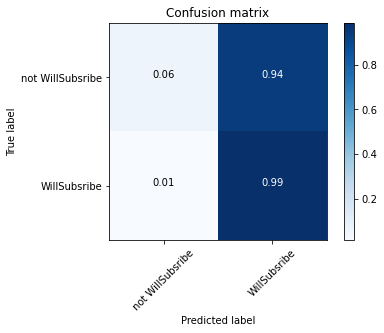

In [62]:
# Visualization Plot of the Confusion Matrix. 
plot_confusion_matrix(cm=confusion_matrix(y_true=y_true, y_pred=y_pred),
                      class_names=["not WillSubsribe", "WillSubsribe"])

In [63]:
#Roc_Auc Score is 59.3%. Auc = area under curve. Roc = receiver operating characteristic curve  
# Roc is a graph depicting the performance of a classification model at all classification thresholds. 
#This curve plots two parameters: True Positive Rate. False Positive Rate.
roc_auc_score(y_true=y_true, y_score=y_score)





0.5933557222222221

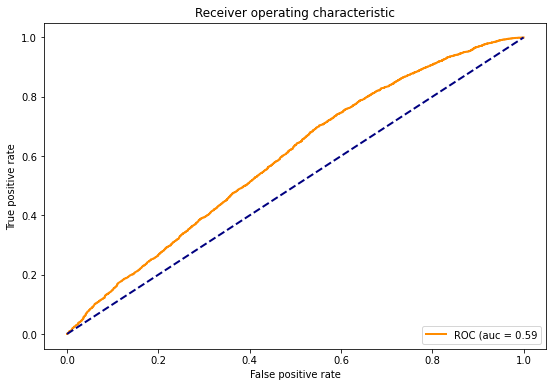

In [56]:
#Visualization Plot of the Roc_Auc Curve/Score   Roc is in orange, Auc is the dotted blue line. 
plot_roc_curve(y_true=y_true, y_score=y_score)